In [75]:
all_vendors_models=[
    {"vendor": "openai", "model": "gpt-4o-2024-05-13", "model_name": "GPT-4o"},
    {"vendor": "anthropic", "model": "claude-3-sonnet-20240229", "model_name": "Claude-3-sonnet"},
    {"vendor": "openrouter", "model": "google/gemini-flash-1.5", "model_name": "Gemini-flash-1.5"},
    {"vendor": "openrouter", "model": "liuhaotian/llava-yi-34b", "model_name": "LLaVA v1.6 34B"}, 
]
# load all the modules local again instead of cache
%load_ext autoreload
%autoreload 2
# Import the required libraries
import os
import json
import base64
import asyncio
import aiohttp
import time
from anthropic import Anthropic
from PIL import Image
import io
import pandas as pd
import numpy as np
import random
from sklearn.utils import shuffle
import nest_asyncio
from tqdm import tqdm
import re
from data_loader import load_and_prepare_data_SBRD, load_and_prepare_data_DurumWheat, load_and_prepare_data_soybean_seeds, load_and_prepare_data_mango_leaf, load_and_prepare_data_DeepWeeds, load_and_prepare_data_IP02, load_and_prepare_data_bean_leaf, load_and_prepare_data_YellowRust, load_and_prepare_data_FUSARIUM22, load_and_prepare_data_InsectCount
nest_asyncio.apply()
global vision_prompt
vision_prompt = ""
def extract_json(s):
    """Extract the first JSON object from a string."""
    json_match = re.search(r'\{.*\}', s, re.DOTALL)
    if json_match:
        try:
            return json.loads(json_match.group())
        except json.JSONDecodeError:
            return None
    return None

def load_image(image_path: str) -> str:
    """
    Load image from file, convert to JPEG, and encode as base64.
    """
    try:
        with Image.open(image_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            buffer = io.BytesIO()
            img.save(buffer, format="JPEG", quality=95)
            return base64.b64encode(buffer.getvalue()).decode('utf-8')
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

class RateLimiter:
    def __init__(self, max_requests, time_window):
        self.max_requests = max_requests
        self.time_window = time_window
        self.request_times = []

    async def wait(self):
        while True:
            current_time = time.time()
            self.request_times = [t for t in self.request_times if t > current_time - self.time_window]
            if len(self.request_times) < self.max_requests:
                self.request_times.append(current_time)
                break
            await asyncio.sleep(0.1)

class GPTAPI:
    def __init__(self, api_key, model):
        self.api_key = api_key
        self.model = model
        self.url = "https://api.openai.com/v1/chat/completions"
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}"
        }
        self.rate_limiter = RateLimiter(max_requests=10, time_window=10)

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        payload = {
            "model": self.model,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": inputs['prompt']},
                        *inputs['examples'],
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{inputs['image']}",
                                "detail": "high"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 4096, 
            "temperature":1.0
        }
        async with aiohttp.ClientSession() as session:
            async with session.post(self.url, headers=self.headers, json=payload) as response:
                result = await response.json()
                if "choices" in result and result["choices"]:
                    return result["choices"][0]['message']['content']
                else:
                    raise Exception(f"Unexpected API response format: {result}")

class ClaudeAPI:
    def __init__(self, api_key, model):
        self.client = Anthropic(api_key=api_key)
        self.model = model
        self.rate_limiter = RateLimiter(max_requests=5, time_window=60)  # Adjust these values as needed

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": inputs['prompt']},
                    *[
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/jpeg",
                                "data": ex['image_url']['url'].split(',')[1] if ex['type'] == 'image_url' else ex['source']['data']
                            }
                        }
                        if ex['type'] in ['image_url', 'image'] else ex
                        for ex in inputs['examples']
                    ],
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": inputs['image']
                        }
                    }
                ]
            }
        ]
        response = self.client.messages.create(
            model=self.model,
            max_tokens=4096,
            temperature=1.0,
            messages=messages
        )
        return response.content[0].text
# Set the base directory


class OpenRouterAPI:
    def __init__(self, api_key, model):#  liuhaotian/llava-yi-34b
        self.api_key = api_key
        self.model = model
        self.url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}",
        }
        self.rate_limiter = RateLimiter(max_requests=5, time_window=10)  # Adjust as needed

    async def get_image_information(self, inputs: dict) -> str:
        await self.rate_limiter.wait()
        payload = {
            "model": self.model,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": inputs['prompt']},
                        *inputs['examples'],
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{inputs['image']}"
                            }
                        }
                    ]
                }
            ],
            "temperature":1.0
        }
        async with aiohttp.ClientSession() as session:
            async with session.post(self.url, headers=self.headers, json=payload) as response:
                result = await response.json()
                if "choices" in result and result["choices"]:
                    return result["choices"][0]['message']['content']
                else:
                    raise Exception(f"Unexpected API response format: {result}")

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Processing images")

    def update(self):
        self.pbar.update(1)

    def close(self):
        self.pbar.close()

################################################################################################################################################################
total_samples_to_check = 10
vendor, model, model_name =all_vendors_models[0].values() # index 2 is gemini, 3 is llava

async def process_image(api, i, number_of_shots, all_data_results, all_data, progress_bar):
    try:
        image_path = all_data[0][i]
        image_base64 = load_image(image_path)
        if image_base64 is None:
            raise ValueError(f"Failed to load image: {image_path}")
        
        examples = []
        example_paths = []
        example_categories = []
        num_rows = len(all_data)
        random_indices = random.sample([idx for idx in range(num_rows) if idx != i], number_of_shots)

        for j in random_indices:
            example_image_path = all_data[0][j]
            example_image_base64 = load_image(example_image_path)
            if example_image_base64 is not None:
                if isinstance(api, GPTAPI) or isinstance(api, OpenRouterAPI):
                    examples.append({"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{example_image_base64}", "detail": "high"}})
                elif isinstance(api, ClaudeAPI):
                    examples.append({
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": example_image_base64
                        }
                    })
                examples.append({"type": "text", "text": f'{{"prediction": "{all_data.at[j, 1]}"}}' })
                example_paths.append(example_image_path)
                example_categories.append(all_data.at[j, 1])

        prediction = await api.get_image_information({"image": image_base64, "examples": examples, "prompt": vision_prompt})
        
        try:
            extracted_json = extract_json(prediction)
            parsed_prediction = extracted_json['prediction']
        except Exception as e:
            print(f"Error parsing JSON for image {image_path}. API response: {prediction}. Error: {str(e)}")
            parsed_prediction = 'NA'


        all_data_results.at[i, f"# of Shots {number_of_shots}"] = parsed_prediction
        all_data_results.at[i, f"Example Paths {number_of_shots}"] = str(example_paths) # removed json.dump from here. 
        all_data_results.at[i, f"Example Categories {number_of_shots}"] = str(example_categories)

    except Exception as e:
        print(f"Error processing {all_data[0][i]}: {str(e)}")
        all_data_results.at[i, f"# of Shots {number_of_shots}"] = 'NA'
        all_data_results.at[i, f"Example Paths {number_of_shots}"] = 'NA'
        all_data_results.at[i, f"Example Categories {number_of_shots}"] = 'NA'
    finally:
        progress_bar.update()

async def process_images_for_shots(api, number_of_shots, all_data_results, all_data):
    progress_bar = ProgressBar(len(all_data))
    tasks = []
    for i in range(len(all_data)):
        task = asyncio.ensure_future(process_image(api, i, number_of_shots, all_data_results, all_data, progress_bar))
        tasks.append(task)
    
    await asyncio.gather(*tasks)
    progress_bar.close()

async def main():
    all_data, expected_classes,output_file_name = load_and_prepare_data_InsectCount( total_samples_to_check)
    global vision_prompt
    # vision_prompt = f"""
    # Given the image, identify the class. Use the following list of possible classes for your prediction It should be one of the : {expected_classes}. Be attentive to subtle details as some classes may appear similar. Provide your answer in the following JSON format:
    # {{"prediction": "class_name"}}
    # Replace "class_name" with the appropriate class from the list above based on your analysis of the image.
    # The labels should be entered exactly as they are in the list above i.e., {expected_classes}.
    # The response should start with {{ and contain only a JSON object (as specified above) and no other text.
    # """
    
    # Quantification Task 1
    # vision_prompt = f"""
    # Analyze this image of a maize plant leaf. Identify any areas affected by Northern Leaf Blight. Estimate the ratio of diseased area to total leaf area as a percentage number. Be attentive to subtle details as some classes may appear similar. Provide your answer in the following JSON format:
    # {{"prediction": "number"}}
    # Replace "number" with the appropriate number based on your analysis of the image.
    # The number should be entered exactly as a whole number between 0 and 100.
    # The response should start with {{ and contain only a JSON object (as specified above) and no other text.
    # """
    # Quantification Task 2
    vision_prompt = f"""
    Analyze this image of a yellow sticky insect trap. Count the total number of visible insects caught on the trap. Only look for insects which are easily visible to nacked eye and look bigger compared to the other background artifacts.  Provide your answer in the following JSON format:
    {{"prediction": "number"}}
    Replace "number" with your best estimate of the total insect count based on your analysis of the image.
    The number should be entered exactly as a whole number in a range of {expected_classes}
    The response should start with {{ and contain only a JSON object (as specified above) and no other text.
    """



    all_data_results = all_data.copy(deep=True)
    all_data_results.columns = all_data_results.columns.map(str)

    if vendor == "openai":
        api = GPTAPI(api_key=os.getenv("OPENAI_API_KEY"), model=model)
    elif vendor == "anthropic":
        api = ClaudeAPI(api_key=os.getenv("ANTHROPIC_API_KEY"), model=model)
    elif vendor == "openrouter":
        api = OpenRouterAPI(api_key=os.getenv("OPENROUTER_API_KEY"), model=model)
    else:
        raise ValueError(f"Unsupported model type: {vendor}")

    # print we are running model model_name and output_file_name
    print(f"Running model: {model_name} \nover dataset: {output_file_name}.csv")

    # 
    # 
    #  
    for number_of_shots in [0,4,8]:  # [0, 1, 2, 4, 8]:
        print(f"Running with {number_of_shots} shots")
        await process_images_for_shots(api, number_of_shots, all_data_results, all_data)
    
    # Create the results directory structure
    results_dir = os.path.join("results", model_name)
    os.makedirs(results_dir, exist_ok=True)
    
    # Save the results file
    output_file = os.path.join(results_dir, f"{output_file_name}.csv")
    all_data_results.to_csv(output_file)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    asyncio.run(main()) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded 10 samples from /Users/muhammadarbabarshad/Downloads/AgEval-datasets/insectcount/train
Label range: 0 to 6
Running model: GPT-4o 
over dataset: InsectCount.csv
Running with 0 shots


Processing images: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Running with 4 shots


Processing images: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Running with 8 shots


Processing images: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

Results saved to results/GPT-4o/InsectCount.csv


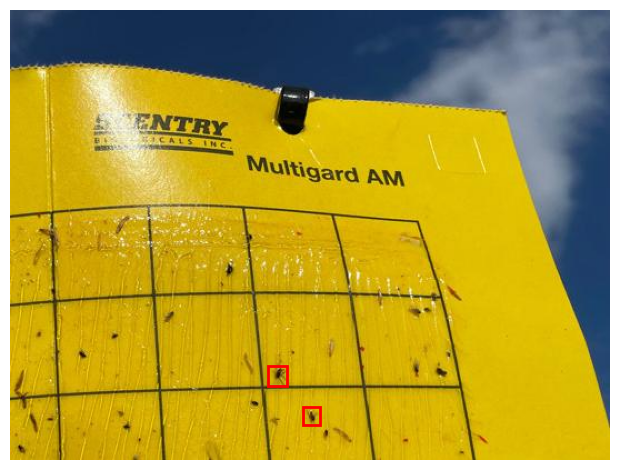